In [1]:
import sys
sys.path.append('..')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import taiko as tk
from taiko.tools.config import *
from taiko.play import get_play, get_similarity
from taiko.database import load_record_df

from itertools import product
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import posixpath
import multiprocessing
from sklearn.preprocessing import StandardScaler

sns.set(font_scale=1.5)

Using TensorFlow backend.


In [3]:
SONG_ID = 2

In [4]:
record_df = load_record_df(song_id=SONG_ID)
record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime
2,aaaaa,2,L_2018-09-28_111610.csv,R_2018-09-28_111611.csv,capture_2018_09_28_11_16_11
6,aaaaa,2,L_2018-09-28_113242.csv,R_2018-09-28_113244.csv,capture_2018_09_28_11_32_44
10,aaaaa,2,L_2018-09-28_114710.csv,R_2018-09-28_114713.csv,capture_2018_09_28_11_47_13
14,aaaaa,2,L_2018-09-28_120045.csv,R_2018-09-28_120046.csv,capture_2018_09_28_12_00_46
26,carolyn,2,L_2018-09-27_155227.csv,R_2018-09-27_155228.csv,capture_2018_09_27_15_52_28
30,carolyn,2,L_2018-09-27_160748.csv,R_2018-09-27_160749.csv,capture_2018_09_27_16_07_48
34,carolyn,2,L_2018-09-27_162052.csv,R_2018-09-27_162053.csv,capture_2018_09_27_16_20_53
38,carolyn,2,L_2018-09-27_163339.csv,R_2018-09-27_163341.csv,capture_2018_09_27_16_33_40
44,celiven,2,L_2018-09-22_142409.csv,R_2018-09-22_142408.csv,capture_2018_09_22_14_24_08
48,celiven,2,L_2018-09-22_143511.csv,R_2018-09-22_143511.csv,capture_2018_09_22_14_35_11


In [5]:
play_result_df = pd.read_csv(PLAY_RESULT_TABLE_PATH)
play_result_df.drop(['drummer_name', 'song_id', 'capture_datetime'], axis=1, inplace=True)
play_record_df = record_df.merge(play_result_df, left_index=True, right_on='id', how='inner')
play_record_df['note'] = play_record_df['good'] + play_record_df['ok'] + play_record_df['bad']
play_record_df = play_record_df[play_record_df['note'] == ALL_NOTE_COUNT_DICT[SONG_ID]]
play_record_df.drop('note', axis=1, inplace=True)
play_record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
1,aaaaa,2,L_2018-09-28_111610.csv,R_2018-09-28_111611.csv,capture_2018_09_28_11_16_11,2,1,998510,126,1,0,127,79
5,aaaaa,2,L_2018-09-28_113242.csv,R_2018-09-28_113244.csv,capture_2018_09_28_11_32_44,6,2,987140,123,4,0,127,75
9,aaaaa,2,L_2018-09-28_114710.csv,R_2018-09-28_114713.csv,capture_2018_09_28_11_47_13,10,3,993920,126,1,0,127,72
13,aaaaa,2,L_2018-09-28_120045.csv,R_2018-09-28_120046.csv,capture_2018_09_28_12_00_46,14,4,987340,124,3,0,127,77
17,carolyn,2,L_2018-09-27_155227.csv,R_2018-09-27_155228.csv,capture_2018_09_27_15_52_28,26,1,830270,95,26,6,76,59
21,carolyn,2,L_2018-09-27_160748.csv,R_2018-09-27_160749.csv,capture_2018_09_27_16_07_48,30,2,852710,95,27,5,120,64
25,carolyn,2,L_2018-09-27_162052.csv,R_2018-09-27_162053.csv,capture_2018_09_27_16_20_53,34,3,849120,91,35,1,92,64
29,carolyn,2,L_2018-09-27_163339.csv,R_2018-09-27_163341.csv,capture_2018_09_27_16_33_40,38,4,945850,114,13,0,127,63
33,celiven,2,L_2018-09-22_142409.csv,R_2018-09-22_142408.csv,capture_2018_09_22_14_24_08,44,1,964300,119,8,0,27,7
36,celiven,2,L_2018-09-22_143511.csv,R_2018-09-22_143511.csv,capture_2018_09_22_14_35_11,48,2,964900,118,9,0,27,0


In [6]:
full_combo_df = play_record_df[play_record_df['bad'] == 0]
full_combo_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
1,aaaaa,2,L_2018-09-28_111610.csv,R_2018-09-28_111611.csv,capture_2018_09_28_11_16_11,2,1,998510,126,1,0,127,79
5,aaaaa,2,L_2018-09-28_113242.csv,R_2018-09-28_113244.csv,capture_2018_09_28_11_32_44,6,2,987140,123,4,0,127,75
9,aaaaa,2,L_2018-09-28_114710.csv,R_2018-09-28_114713.csv,capture_2018_09_28_11_47_13,10,3,993920,126,1,0,127,72
13,aaaaa,2,L_2018-09-28_120045.csv,R_2018-09-28_120046.csv,capture_2018_09_28_12_00_46,14,4,987340,124,3,0,127,77
29,carolyn,2,L_2018-09-27_163339.csv,R_2018-09-27_163341.csv,capture_2018_09_27_16_33_40,38,4,945850,114,13,0,127,63
33,celiven,2,L_2018-09-22_142409.csv,R_2018-09-22_142408.csv,capture_2018_09_22_14_24_08,44,1,964300,119,8,0,27,7
36,celiven,2,L_2018-09-22_143511.csv,R_2018-09-22_143511.csv,capture_2018_09_22_14_35_11,48,2,964900,118,9,0,27,0
39,celiven,2,L_2018-09-22_144531.csv,R_2018-09-22_144530.csv,capture_2018_09_22_14_45_30,52,3,961210,118,9,0,27,1
41,celiven,2,L_2018-09-22_145638.csv,R_2018-09-22_145638.csv,capture_2018_09_22_14_56_37,56,4,975270,121,6,0,27,98
57,chris,2,L_2018-09-26_141236.csv,R_2018-09-26_141237.csv,capture_2018_09_26_14_12_37,73,4,974870,124,3,0,127,64


In [7]:
# CONSIDERED_IDS = [1, 5, 33, 37, 61, 65, 99, 107, 141, 150, 180, 181, 241, 249, 254, 258, 288, 310, 323, 327]
# CONSIDERED_IDS = [1, 33, 61, 99, 141, 180, 241, 254, 288, 323]
CONSIDERED_IDS = [10, 14, 52, 56, 79, 83, 121, 125, 155, 159, 208, 216, 280, 284, 311, 315, 350, 354]

In [8]:
plays = []
with multiprocessing.Pool() as p:
    record_rows = [record_df.loc[id_] for id_ in CONSIDERED_IDS]
    for _, play in tqdm(enumerate(p.imap(get_play, record_rows)), total=len(record_rows)):
        plays.append(play)

play_record_df[play_record_df['id'].isin(CONSIDERED_IDS)]

100%|██████████| 18/18 [01:04<00:00,  3.60s/it]


,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
9,aaaaa,2,L_2018-09-28_114710.csv,R_2018-09-28_114713.csv,capture_2018_09_28_11_47_13,10,3,993920,126,1,0,127,72
13,aaaaa,2,L_2018-09-28_120045.csv,R_2018-09-28_120046.csv,capture_2018_09_28_12_00_46,14,4,987340,124,3,0,127,77
39,celiven,2,L_2018-09-22_144531.csv,R_2018-09-22_144530.csv,capture_2018_09_22_14_45_30,52,3,961210,118,9,0,27,1
41,celiven,2,L_2018-09-22_145638.csv,R_2018-09-22_145638.csv,capture_2018_09_22_14_56_37,56,4,975270,121,6,0,27,98
62,chris,2,L_2018-10-01_191950.csv,R_2018-10-01_191948.csv,capture_2018_10_01_19_19_49,79,5,985640,123,4,0,127,65
66,chris,2,L_2018-10-01_193436.csv,R_2018-10-01_193434.csv,capture_2018_10_01_19_34_34,83,6,971180,120,7,0,127,64
102,cuxi,2,L_2018-09-26_121546.csv,R_2018-09-26_121547.csv,capture_2018_09_26_12_15_47,121,7,971880,119,8,0,127,68
106,cuxi,2,L_2018-09-26_122742.csv,R_2018-09-26_122743.csv,capture_2018_09_26_12_27_43,125,8,950140,117,10,0,127,67
134,eve,2,L_2018-09-28_164924.csv,R_2018-09-28_164925.csv,capture_2018_09_28_16_49_25,155,7,917230,107,20,0,127,63
138,eve,2,L_2018-09-28_170310.csv,R_2018-09-28_170311.csv,capture_2018_09_28_17_03_12,159,8,956320,117,10,0,127,61


In [9]:
similarity_mat = []
with multiprocessing.Pool() as p:
    result = p.starmap(get_similarity, product(plays, repeat=2))
    ids = list(product(CONSIDERED_IDS, repeat=2))
    for ids_, sim in zip(ids, result):
        similarity_mat.append(list(ids_) + list(sim))
#         sim = get_similarity(row1[1], row2[1])
#         similarity_mat.append([row1[0], row2[0], sim[0], sim[1]])
#         print(sim)


similarity_df = pd.DataFrame(data=similarity_mat)
similarity_df.columns = ['a_id', 'b_id', 'acc_dtw', 'gyr_dtw']
similarity_df

,a_id,b_id,acc_dtw,gyr_dtw
0,10,10,0.000000,0.000000e+00
1,10,14,41216.018970,5.630673e+05
2,10,52,61109.597982,1.113150e+06
3,10,56,57027.809183,9.577251e+05
4,10,79,44704.950170,6.570875e+05
5,10,83,43118.979850,6.245198e+05
6,10,121,50442.795233,8.029525e+05
7,10,125,51326.242693,7.497405e+05
8,10,155,50903.649199,6.948730e+05
9,10,159,49448.298904,6.907164e+05


In [10]:
scaler = StandardScaler()

dtw_df = similarity_df.copy()
dtw_df['same'] = (dtw_df['a_id'] == dtw_df['b_id'])
dtw_df = dtw_df[~dtw_df['same']].drop('same', axis=1)
dtw_df[['acc_dtw', 'gyr_dtw']] = scaler.fit_transform(dtw_df[['acc_dtw', 'gyr_dtw']])
dtw_df['acc_dtw'] -= dtw_df.min(axis=0)['acc_dtw']
dtw_df['gyr_dtw'] -= dtw_df.min(axis=0)['gyr_dtw']
dtw_df['norm_dtw'] = np.sqrt(dtw_df['acc_dtw'] ** 2 + dtw_df['gyr_dtw'] ** 2)
dtw_df

,a_id,b_id,acc_dtw,gyr_dtw,norm_dtw
1,10,14,2.040106,1.658542,2.629220
2,10,52,4.269706,5.404340,6.887472
3,10,56,3.812234,4.345974,5.781056
4,10,79,2.431133,2.298775,3.345859
5,10,83,2.253383,2.077005,3.064585
6,10,121,3.074210,3.292046,4.504257
7,10,125,3.173223,2.929698,4.318851
8,10,155,3.125860,2.556076,4.037887
9,10,159,2.962750,2.527772,3.894550
10,10,208,3.229776,3.090607,4.470269


In [11]:
vis_right_df = play_record_df.copy()
vis_right_df = vis_right_df[['drummer_name', 'id']]

dtw_df = dtw_df.merge(vis_right_df, left_on='a_id', right_on='id', how='inner')
dtw_df = dtw_df.merge(vis_right_df, left_on='b_id', right_on='id', how='inner')
dtw_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
dtw_df = dtw_df.rename(index=str, columns={'drummer_name_x': 'a_drummer_name',
                                  'drummer_name_y': 'b_drummer_name'})
dtw_df['a_id'] = dtw_df['a_id'].apply(str)
dtw_df['b_id'] = dtw_df['b_id'].apply(str)
dtw_df['play1'] = dtw_df[['a_drummer_name', 'a_id']].apply(lambda x: '-'.join(x), axis=1)
dtw_df['play2'] = dtw_df[['b_drummer_name', 'b_id']].apply(lambda x: '-'.join(x), axis=1)

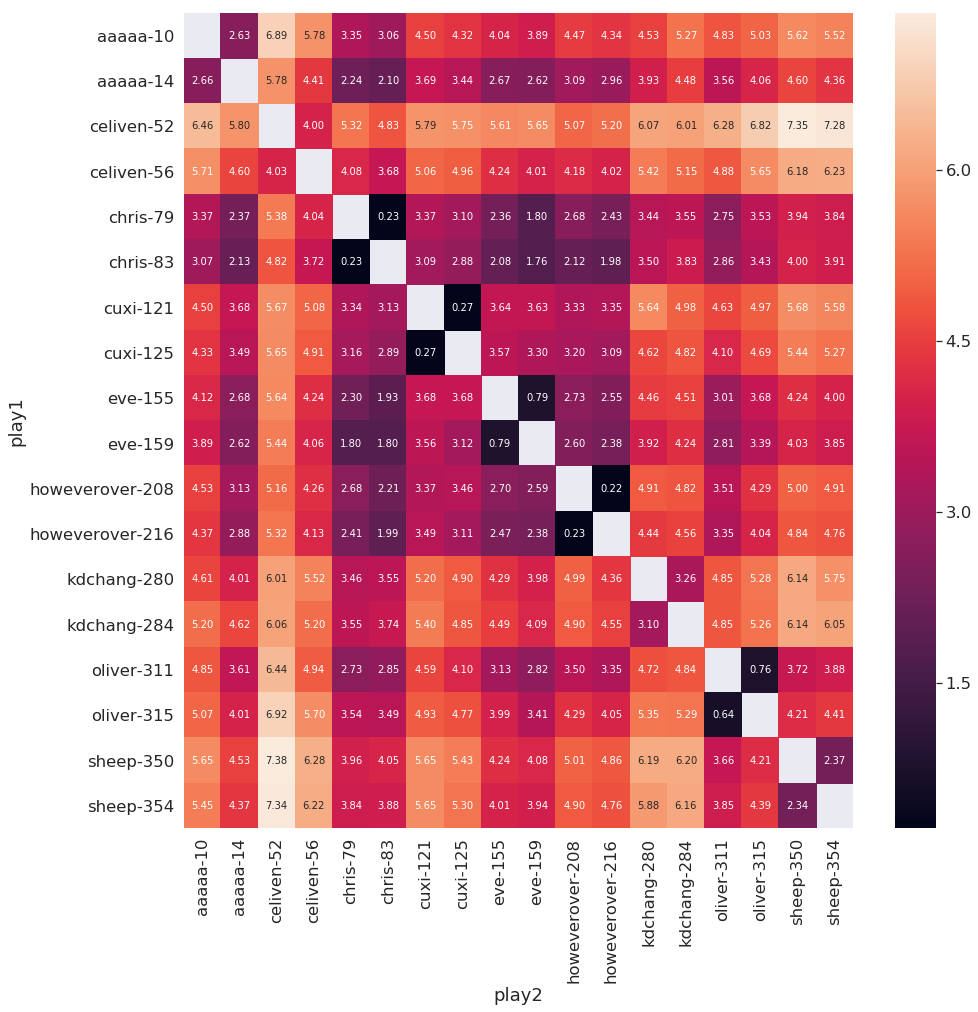

In [12]:
vis_df = dtw_df.pivot('play1', 'play2', 'norm_dtw')
plt.figure(figsize=(15, 15))
ax = sns.heatmap(vis_df, annot=True, fmt='.2f')